In [ ]:
# create the non-Gaussian table

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

matplotlib.rcParams['figure.figsize'] = [12, 7]

In [3]:
instrument = 'amsua'
channel    = 'ch1'
stdev_from = 'OmF'
#predictor  = 'no_predictor'
predictor  = 'sym_cld'
#predictor = 'obs_cld'
expid     = 'old_ctrl'

In [4]:
fn = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/compile_radstats/csv_files/default_used_to_build_pdfs/omf_stats_{instrument}_{channel}.csv'
df = pd.read_csv(fn)

In [5]:
clw_sym  = 0.5*(df['clw_obs'].to_numpy() + df['clw_bg'].to_numpy())
clw_diff = df['clw_obs'].to_numpy() - df['clw_bg'].to_numpy()
clw_obs  = df['clw_obs'].to_numpy()
clw_bg   = df['clw_bg'].to_numpy()
symerr   = df['symerr'].to_numpy()
inverr   = df['errinv'].to_numpy()
qc       = df['qcmark'].to_numpy()
omf      = df['omf'].to_numpy()

fwater   = df['fwater'].to_numpy()
fland    = df['fland'].to_numpy()
lat      = df['lat'].to_numpy()
lon      = df['lon'].to_numpy()

In [25]:
# criterion used to select data:

# need to decide how much "over land" data should be screen out:
land_sea_screen = (fwater > 0.99) & (fland < 0.01) & (abs(omf) < 1e3)
land_screen     = (fland >= 0.99) & (abs(omf) < 1e3)

#screen = land_sea_screen
screen = land_screen

omf_screen      = omf[screen]
clw_obs_screen  = clw_obs[screen]
clw_bg_screen   = clw_bg [screen]
clw_sym_screen  = clw_sym[screen]
clw_diff_screen = clw_diff[screen]

print("original data size = ",len(omf))
print("screened data size = ",len(omf_screen))

original data size =  18327123
screened data size =  1471752


In [ ]:
# have a look at the smallest 1000 and largest 1000 omf:
plt.plot(np.sort(omf_screen)[:1000])
plt.show()
plt.plot(np.sort(omf_screen)[-1000:])
plt.show()

/tmp/ipykernel_1003890/740321982.py:29: RuntimeWarning: divide by zero encountered in log
  plt.plot(gauss_range, np.log(hist_gauss_fit), linestyle='--', linewidth=2, color=(0,0,0), label='Gaussian fit')
/tmp/ipykernel_1003890/740321982.py:30: RuntimeWarning: divide by zero encountered in log
  plt.plot(bin_centers, np.log(hist),           linewidth=2, label=f'{instrument}-{channel}')


Text(0.5, 1.0, ' OmF PDF over land amsua ch1 mean = -0.01 stdev = 1.73')

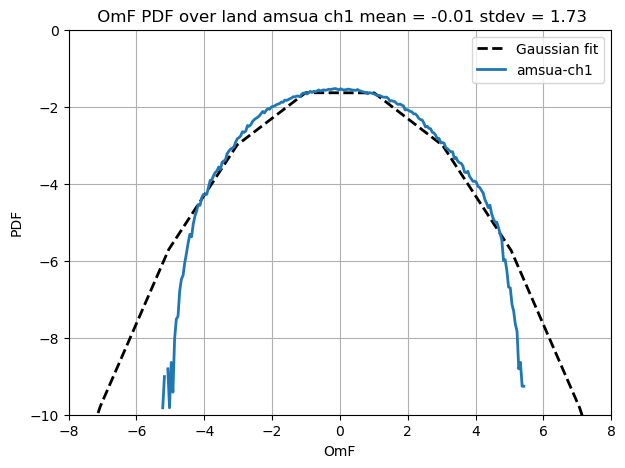

In [36]:
# only for land data (no symmetric cloud defined)

mean_omf  = np.mean(omf_screen) 
stdev_omf = np.std(omf_screen)

#print("mean O-B for "+instrument+" "+channel+" is ", np.mean(omf_screen))
#print("stdev O-B for "+instrument+" "+channel+" is ", np.std(omf_screen))

# O-B histogram
inflation = 1
q1 = np.percentile(omf_screen, 25)
q3 = np.percentile(omf_screen, 75)
size_omf  = len(omf_screen) 
dx_diag   = 2*(q3-q1)/size_omf**(1/3)
dx_actual = np.ceil(inflation*dx_diag/0.01)*0.01

max_val = (np.ceil(max(omf_screen)/dx_actual)+10)*dx_actual
min_val = (np.floor(min(omf_screen)/dx_actual)-10)*dx_actual
axis_omf = np.arange(min_val, max_val+dx_actual, dx_actual)


fig = plt.figure(figsize=(7,5))
hist, bin_edges = np.histogram(omf_screen, bins=axis_omf, density=True)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

gauss_range = np.linspace(-100,100,100)
hist_gauss_fit = 1/(stdev_omf * np.sqrt(2 * np.pi)) * np.exp( - (gauss_range - mean_omf)**2 / (2 * stdev_omf**2) )

plt.plot(gauss_range, np.log(hist_gauss_fit), linestyle='--', linewidth=2, color=(0,0,0), label='Gaussian fit')
plt.plot(bin_centers, np.log(hist),           linewidth=2, label=f'{instrument}-{channel}')
plt.grid(True)
if instrument == 'amsua':
    if channel == 'ch1':
        plt.xlim(-8,8)
        plt.ylim(-10,0)
plt.xlabel('OmF')
plt.ylabel('PDF')
plt.legend()
plt.title(f' OmF PDF over land {instrument} {channel} mean = {mean_omf:.2f} stdev = {stdev_omf:.2f}')
#plt.savefig(f'omf_over_land_{instrument}_{channel}.png', dpi=300, bbox_inches='tight')


In [ ]:
# manually collect dataset into categories based on the symmetric cloud amount:
# define the edges used for the histogram
dcloud     = 0.05 
domf_init  = 0.05 # a first-guess d(omf)

# please refer to
# /scratch2/GFDL/gfdlscr/Chih-Chi.Hu/SHiELD/shield_workflow/fix/fix_gsi/cloudy_radiance_info_shield.txt
# to determine how to categorize the cloud bin

if predictor in ('obs_cld','sym_cld'):
    if instrument == 'amsua':
        if channel in ('ch1','ch2','ch3','ch4'):
            cloud_edge = np.array([0.00, 0.03, \
                                   0.06, 0.10, \
                                   0.15, 0.20, \
                                   0.25, 0.30, \
                                   0.35, 1.00 ])
        elif channel in ('ch5'):
            cloud_edge = np.array([0.00, 0.03, \
                                   0.06, 0.10, \
                                   0.15, 0.20, \
                                   0.25, 0.30, \
                                   0.35, 0.40, 1.00])
        elif channel in ('ch15'):
            cloud_edge = np.array([0.00, 0.03, \
                                   0.06, 0.10, \
                                   0.15, 0.20, \
                                   0.25, 1.00])
    elif instrument == 'atms':
        if channel in ('ch1','ch2','ch3','ch4','ch5','ch16'):
            cloud_edge = np.array([0.00, 0.03, \
                                   0.06, 0.10, \
                                   0.15, 0.20, \
                                   0.25, 0.30, \
                                   0.35, 1.00 ]) 
        elif channel in ('ch6','ch18'):
            cloud_edge = np.array([0.00, 0.03, \
                                   0.06, 0.10, \
                                   0.15, 0.20, \
                                   0.25, 0.30, \
                                   0.35, 0.40, \
                                   0.45, 1.00])
        elif channel in ('ch17'):
            cloud_edge = np.array([0.00, 0.03, \
                                   0.06, 0.10, \
                                   0.15, 0.20, \
                                   0.25, 0.30, 1.00])
        elif channel in ('ch19','ch20','ch21','ch22'):
            cloud_edge = np.array([0.00, 0.03, \
                                   0.06, 0.10, \
                                   0.15, 0.20, \
                                   0.25, 0.30, \
                                   0.35, 0.40, \
                                   0.55, 1.00])
            
elif predictor == 'no_predictor':
    cloud_edge = np.array([0.00, 1.00])

#cloud_edge = np.array([0.00, 0.03, 0.06, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 1.00])

n_cat      = len(cloud_edge)-1  # number of cloud bins

# inflation factor for the diagnosed bin-width
inflation = 3

idx_cat  = [] # the index of the cloud samples in each cat
size_cat = [] # the sample size in each cat
omf_cat  = [] # the corresponding omf
dx_diag_cat   = [] # the diagnosed optimal binwidth for each cat
dx_actual_cat = [] # the actually used binwidth for each cat
axis_omf_cat  = [] # the x-axis for the histogram defined in each cat 
hist_omf_cat  = [] # the density of the histogram
stdev_cat     = [] # the standard deviation of each cat
mean_cat      = [] # the mean of each cat

for i in range(n_cat):
    print("processing the ",i+1,"-th cloud bin...")
    #idx_cat.append( np.where( (clw_diff_screen>=cloud_edge[i])&(clw_diff_screen<cloud_edge[i+1]) ) )
    if predictor== 'sym_cld':
        idx_cat.append( np.where( (clw_sym_screen>=cloud_edge[i])&(clw_sym_screen<cloud_edge[i+1]) ) )
    elif predictor == 'obs_cld':
        idx_cat.append( np.where( (clw_obs_screen>=cloud_edge[i])&(clw_obs_screen<cloud_edge[i+1]) ) )
    elif predictor == 'no_predictor':
        idx_cat.append( np.where( (clw_obs_screen>=cloud_edge[i])&(clw_obs_screen<cloud_edge[i+1]) ) )

    #idx_cat.append( np.where( (clw_bg_screen>=cloud_edge[i])&(clw_bg_screen<cloud_edge[i+1]) ) )
    
    # define the x-axis for the histogram of omf in each cat
    # first define dx (using IQR):
    omf_cat.append( omf_screen[idx_cat[i]] )
    q1 = np.percentile(omf_cat[i], 25)
    q3 = np.percentile(omf_cat[i], 75)
    size_cat.append( len(idx_cat[i][0]) )
    dx_diag_cat.append( 2*(q3-q1)/size_cat[i]**(1/3))
    dx_actual_cat.append( np.ceil(inflation*dx_diag_cat[i]/domf_init)*domf_init )
    stdev_cat.append(np.std(omf_cat[i]))
    mean_cat.append(np.mean(omf_cat[i]))

    # determine the max/min value based on the above dx
    max_val = (np.ceil(max(omf_screen)/dx_actual_cat[i])+5)*dx_actual_cat[i]
    min_val = (np.floor(min(omf_screen)/dx_actual_cat[i])-5)*dx_actual_cat[i]
    axis_omf_cat.append(np.arange(min_val, max_val+dx_actual_cat[i], dx_actual_cat[i]))
    
    # generate the histogram
    hist, bin_edges = np.histogram(omf_cat[i], bins=axis_omf_cat[i], density=True)
    hist_omf_cat.append(hist)
    
    # summary statistics:
    print("for cloud amount = [",cloud_edge[i],",",cloud_edge[i+1],"]")
    print("the size of this cat = ", size_cat[i])
    print("mean of this cat = ",  mean_cat[i] )
    print("stdev of this cat = ", stdev_cat[i])
    #print("min omf screen = ", min(omf_screen))
    print("dx_actual_cat = ", dx_actual_cat[i])
    #print("min value = ", min_val)
    #print("max value = ", max_val)
    print(" ")
#print("diagnosed binwidth = ", dx_diag_cat)
#print("actual binwdith = ", dx_actual_cat)

In [ ]:
# have a look at the original symmetric error model

cloud_x = 0.5*(cloud_edge[:-1] + cloud_edge[1:])
#cloud_x = cloud_edge[:-1]

plt.plot(cloud_x, stdev_cat,linestyle='--')
plt.grid(True)
#plt.axvline(x=cloud_edge[0], color='black', linestyle='--', label='clear sky error')
#plt.axvline(x=cloud_edge[-2], color='black', linestyle='--', label='cloudy sky error')
plt.xlabel('symmetric cloud')
plt.ylabel('standard deviation')
plt.title(f'instrument = {instrument}, channel = {channel}, clear = {stdev_cat[0]}, cloudy = {stdev_cat[-1]}')
#plt.savefig(f'orig_symerr_model_{instrument}_{channel}.png', dpi=300, bbox_inches='tight')
#plt.savefig(f'symerr_model_check_turning_pt_{instrument}_{channel}.png', dpi=300, bbox_inches='tight')


In [ ]:
# optional block (experimental...)
# examine the CLW distribution within each cloud bin (2023/11/22)

clw_obs_cat = []  # observation cloud proxy
clw_bg_cat  = []  # background cloud proxy

for i in range(n_cat):
    clw_obs_cat.append(clw_obs_screen[idx_cat[i]])
    clw_bg_cat.append(clw_bg_screen[idx_cat[i]])

In [ ]:
# optional block
# plot the histogram:

for i in range(n_cat):
    hist, bin_edges = np.histogram(clw_obs_cat[i] - clw_bg_cat[i], bins=np.arange(-0.8,0.8,0.01), density=True)
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, hist, linewidth=3)
    plt.grid(True)
    plt.xlabel('obs cloud - bkg cloud')
    plt.xlim(-0.2,0.2)    
    plt.title(f' cloud amount = [{cloud_edge[i]}, {cloud_edge[i+1]}]')
    plt.show()

In [ ]:
# optional block
# plot the histogram:

for i in range(n_cat):
    hist, bin_edges = np.histogram(clw_obs_cat[i], bins=np.arange(0.0,0.8,0.01), density=True)
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, hist, linewidth=3, label='obs cloud pdf')
    
    hist, bin_edges = np.histogram(clw_bg_cat[i], bins=np.arange(0.0,0.8,0.01), density=True)
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, hist, linewidth=3, label='bkg cloud pdf')
    
    plt.grid(True)
    plt.xlabel('cloud proxy CLW')
    plt.xlim(0.0,0.3)    
    plt.title(f' cloud proxy pdf')
    plt.legend()
    plt.show()

In [ ]:
# have a look at the marginal pdfs for each bin:

for i in range(n_cat):
    #hist, bin_edges = np.histogram(omf_cat[i], bins=axis_omf_cat[i], density=True)
    #bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    bin_centers = 0.5*(axis_omf_cat[i][:-1] + axis_omf_cat[i][1:])
    plt.plot(bin_centers, hist_omf_cat[i], label='pdf of Omf', linewidth=3)
    plt.axvline(x=0, color='black', linestyle='--', label='Vertical Line at x=0')
    plt.grid(True)
    if instrument == 'amsua':
        if channel in ('ch1','ch2','ch3','ch15'):
            plt.xlim(-35,65)
        elif channel in ('ch4'):
            plt.xlim(-5 ,10)
        elif channel in ('ch5'):
            plt.xlim(-1.4,2)

    plt.xlim(-20,20)
    plt.xlabel('omf (K)')
    plt.title(f'{predictor} amount = [{cloud_edge[i]}, {cloud_edge[i+1]}]')
    plt.show()


In [ ]:
# regrid the pdfs onto the same grid:

# regrid boundary (HARD CODED!! determined by the plots from the above block)
if predictor in ('sym_cld', 'obs_cld'):
    if instrument == 'amsua':
        if channel in ('ch1','ch2','ch15'):
            bdy_regrid = 60
            dx_regrid  = 0.1
        elif channel in ('ch3'):
            bdy_regrid = 40
            dx_regrid  = 0.1        
        elif channel in ('ch4'):
            bdy_regrid = 15 
            dx_regrid  = 0.05
        elif channel in ('ch5'):
            bdy_regrid = 5
            dx_regrid  = 0.01

    if instrument == 'atms':
        if channel in ('ch1','ch2','ch16'):
            bdy_regrid = 60
            dx_regrid  = 0.1
        elif channel in ('ch3'):
            bdy_regrid = 40
            dx_regrid  = 0.1
        elif channel in ('ch4','ch17','ch18','ch19','ch20','ch21','ch22'):
            bdy_regrid = 20 
            dx_regrid  = 0.05
        elif channel in ('ch5'):
            bdy_regrid = 8
            dx_regrid  = 0.01
        elif channel in ('ch6'):
            bdy_regrid = 5
            dx_regrid  = 0.01
            
elif predictor in ('no_predictor'):
    if instrument == 'amsua':
        if channel in ('ch1','ch2','ch15'):
            bdy_regrid = 60
            dx_regrid  = 0.1
        elif channel in ('ch3'):
            bdy_regrid = 40
            dx_regrid  = 0.1        
        elif channel in ('ch4'):
            bdy_regrid = 15 
            dx_regrid  = 0.05
        elif channel in ('ch5'):
            bdy_regrid = 5
            dx_regrid  = 0.01    
    if instrument == 'atms':
        if channel in ('ch1','ch2','ch16'):
            bdy_regrid = 60
            dx_regrid  = 0.1
        elif channel in ('ch3'):
            bdy_regrid = 40
            dx_regrid  = 0.1
        elif channel in ('ch4','ch17','ch18','ch19','ch20','ch21','ch22'):
            bdy_regrid = 20 
            dx_regrid  = 0.05
        elif channel in ('ch5'):
            bdy_regrid = 8
            dx_regrid  = 0.01
        elif channel in ('ch6'):
            bdy_regrid = 5
            dx_regrid  = 0.01
            
regrid = np.arange(-bdy_regrid, bdy_regrid+dx_regrid, dx_regrid)

hist_omf_regrid_cat = []

for i in range(n_cat):
    xp = 0.5*(axis_omf_cat[i][:-1] + axis_omf_cat[i][1:])
    yp = hist_omf_cat[i]
    hist_omf_regrid_cat.append(np.interp(regrid, xp, yp))


In [ ]:
# define the cost-function

# in order to avoid noises in the cost-function
if instrument == 'amsua':
    min_allow_pdf = 2.5e-4 
elif instrument == 'atms':
    min_allow_pdf = 2.5e-4
        
cost_fn = []

for i in range(n_cat):
    tmp0 = hist_omf_regrid_cat[i].copy()       # very important to copy the array here, otherwise the next line will replace the values in hist_omf_regrid_cat
    tmp0[np.where(tmp0<=min_allow_pdf)] = 0.0
    tmp1 = -np.log(tmp0)
    tmp1[np.isinf(tmp1)] = np.nan
    cost_fn.append(tmp1)
    


In [ ]:
# look at the cost-function 
for i in range(n_cat):
    plt.plot(regrid, cost_fn[i])
    plt.axvline(x=0, color='black', linestyle='--', label='Vertical Line at x=0')
    #plt.xlim([-70,70])
    plt.grid(True)
    plt.title(f'Symmetric cloud amount = [{cloud_edge[i]}, {cloud_edge[i+1]}]')
    plt.show()   

In [ ]:
# polynomial fit with constraints (from scipy)

# Define the polynomial function
def poly_func(x, *coefficients):
    return np.polyval(coefficients[::-1], x)

if predictor in ['obs_cld', 'sym_cld']:
    if instrument == 'amsua':
        if channel in ('ch1','ch2','ch3','ch4','ch15'):
            poly_dim = 8
        elif channel in ('ch5'):
            poly_dim = 8
            
    if instrument == 'atms':
        if channel in ('ch1','ch2','ch3','ch4','ch5','ch6','ch16'):
            poly_dim = 8
        elif channel in ('ch17','ch18'):
            poly_dim = 16
        elif channel in ('ch19','ch20','ch21','ch22'):
            poly_dim = 12

            
elif predictor in ['no_predictor']:
    if instrument == 'amsua':
        if channel in ('ch1','ch2','ch3','ch4','ch5','ch15'):
            poly_dim = 16
    if instrument == 'atms':
        if channel in ('ch1','ch2','ch3','ch4','ch5','ch6','ch19','ch20','ch21','ch22'):
            poly_dim = 16
        elif channel in ('ch16','ch17','ch18'):
            poly_dim = 20


# Fit a polynomial with a positive constant term
initial_guess = np.ones(poly_dim+1)  # Adjust the length based on the polynomial degree
bounds = (np.full(poly_dim+1, -np.inf), np.full(poly_dim+1, np.inf))  
#bounds[0][-1] = 0

fitted_cost_fn = []
fitted_coeff   = []
for i in range(n_cat):
    valid_idx = ~np.isnan(cost_fn[i])
    coefficients, covariance = curve_fit(poly_func, regrid[valid_idx], cost_fn[i][valid_idx], p0=initial_guess, bounds=bounds)
    tmp = poly_func(regrid, *coefficients)
    tmp[~valid_idx] = np.nan
    
    fitted_cost_fn.append(tmp)
    fitted_coeff.append(coefficients)

In [ ]:
# plot the costfunctions (optional)

for i in range(n_cat):
    plt.plot(regrid, cost_fn[i])
    plt.plot(regrid, fitted_cost_fn[i], label='Fitted Curve', color='red')
    plt.axvline(x=0, color='black', linestyle='--', label='Vertical Line at x=0')
    if instrument == 'amsua':
        if channel in ('ch1','ch2','ch15'):
            plt.xlim([-60,60])
            plt.ylim([0,12])
        elif channel in ('ch3'):
            plt.xlim([-40,40])
            plt.ylim([0,12])        
        elif channel in ('ch4'):
            plt.xlim([-15,15])
            plt.ylim([-1,12])
        elif channel in ('ch5'):
            plt.xlim([-3,3])
            plt.ylim([-1,10])

    plt.grid(True)
    plt.title(f'{predictor} amount = [{cloud_edge[i]}, {cloud_edge[i+1]}]')
    plt.show()  

In [ ]:
# identify the mode 
# identify the 'average' mode from regridded pdf (should be the same as the original histogram)

def find_intersections(x_values, y_values):
    # Find indices where y_values change sign (cross y=0)
    sign_changes = np.where(np.diff(np.sign(y_values)))[0]

    # Interpolate to find x-values at sign changes
    x_intersections = np.interp(0, y_values[sign_changes], x_values[sign_changes])

    return x_intersections


mode_cat    = []
mode_idx    = []

for i in range(n_cat):
    fg_top_indices = np.argsort(hist_omf_regrid_cat[i])[-1:]  # used as a first-guess
    min_value      = np.sort(fitted_cost_fn[i][int(fg_top_indices-80):int(fg_top_indices+80)])[0]    
    min_value_idx  = np.where(fitted_cost_fn[i] == min_value)
    mode_value     = regrid[min_value_idx]
    #top_indices    = np.argsort(fitted_cost_fn[i])[:num_avg_pts]
    #avg_idx_of_top = np.mean(regrid[top_indices]) 
    mode_cat.append(mode_value)
    
    # find the index of the mode
    tmp = find_intersections(np.arange(0,len(regrid)), regrid-mode_cat[i])
    mode_idx.append(tmp)

In [ ]:
# check the mode (to see if they are well-identified)
for i in range(n_cat):
    #hist, bin_edges = np.histogram(omf_cat[i], bins=axis_omf_cat[i], density=True)
    #bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    bin_centers = 0.5*(axis_omf_cat[i][:-1] + axis_omf_cat[i][1:])
    #plt.plot(bin_centers, hist_omf_cat[i], label='pdf of Omf', linewidth=3)
    plt.plot(regrid, fitted_cost_fn[i], linewidth=3)
    plt.axvline(mode_cat[i], color='red')
    plt.axvline(x=0, color='black', linestyle='--', label='Vertical Line at x=0')
    plt.grid(True)
    #plt.xlim(-5,5)
    #plt.ylim(-2,10)
    #plt.xticks(np.arange(-35,65,5))
    plt.xlabel('omf (K)')
    plt.title(f'Symmetric cloud amount = [{cloud_edge[i]}, {cloud_edge[i+1]}]')
    plt.show()


In [ ]:
# check if the fitted costfunction gives similar shape in pdf
for i in range(n_cat):
    plt.plot(regrid, hist_omf_regrid_cat[i])
    plt.plot(regrid, np.exp(-fitted_cost_fn[i]))
    plt.xlim([-30,50])
    #plt.ylim([0,0.1])
    plt.axvline(x=0, color='black', linestyle='--', label='Vertical Line at x=0')
    plt.grid(True)
    plt.title(f'Symmetric cloud amount = [{cloud_edge[i]}, {cloud_edge[i+1]}]')
    plt.show()

In [ ]:
# estimate the standard deivation grid-by-grid -- hybrid method (new method: 2023/11/20)
# when far away from the mode, try to derive the analytical solution
# when close to the mode (or to the boundary), use regression (old) method

# Define derivative of a polynomial:
# note that the input coefficients is from low order to high order [a0, a1, a2,...,an]
# while the final_coeff is from high order to low order [a0, a1, a2,...,an]
def local_derivative(x, coefficients):
    tmp = coefficients.copy()
    new_coeff   = tmp[-1:0:-1]
    final_coeff = new_coeff*np.arange(len(coefficients)-1,0,-1)
    return np.polyval(final_coeff, x)


estimate_sig_cat = []

# parameters for regression method:
regression_range    = 1.5     # when |x-mode|<regression_range
#regression_range    = 3     # when |x-mode|<regression_range
width               = 10       # how many points are used to do the quadratic-regression
#width               = 20       # how many points are used to do the quadratic-regression

min_regress_samples = 10       # the minimum number of samples used in the regression 

for j in range(n_cat):
    estimate_sig = np.zeros(len(regrid)) # a dummy vector
    nonGaussian_slope=np.zeros(len(regrid))
    
    for i in range(len(regrid)):
        if np.isnan(fitted_cost_fn[j][i]):
            estimate_sig[i] = np.nan
            
        elif np.abs(regrid[i] - mode_cat[j]) < regression_range: # when close to the mode: regression method
            data_use_idx = np.arange(i-width, i+width)
            sample_x = regrid[data_use_idx] - mode_cat[j]
            #sample_y = cost_fn[j][data_use_idx]
            sample_y = fitted_cost_fn[j][data_use_idx]
            y_is_nan = np.isnan(sample_y)
        
            if sum(y_is_nan) > len(sample_y) - min_regress_samples:
                estimate_sig[i] = np.nan
            else:
                p = np.polyfit(np.square(sample_x[~y_is_nan]), sample_y[~y_is_nan], 1)
            
                if p[0]<0:
                    estimate_sig[i] = np.nan
                else:
                    estimate_sig[i] = np.sqrt(1/(2*p[0]))
               
        #elif fitted_cost_fn[j][i] > 8: 
        #    estimate_sig[i] = np.nan
        else: # otherwise use the analytical solution of the fitted polynomial:
            nonGaussian_slope[i] = local_derivative(regrid[i], fitted_coeff[j])
            temp_val = (regrid[i] - mode_cat[j])/nonGaussian_slope[i]
            if temp_val < 0:
                estimate_sig[i] = estimate_sig[i-1]
            else:
                estimate_sig[i] = np.minimum(np.sqrt(temp_val), 100)
                #estimate_sig[i] = np.sqrt((regrid[i] - mode_cat[j])/nonGaussian_slope[i])
        #end if
    #end for
            
    estimate_sig_cat.append(estimate_sig)
    #plt.plot(regrid, (regrid - mode_cat[j])/nonGaussian_slope)
    #plt.show()
    

In [ ]:
# record the stdev (2023/11/20):

# need to determine the 'boundary' of "trustable" range:
range_min_idx = []
range_max_idx = []
record_sig    = []


# parameters:
if predictor in ('obs_cld','sym_cld'):
    if instrument == 'amsua':
        if channel in ('ch1','ch2','ch3','ch4','ch15'):
            critical_cost_val = 6.5
            extrap_slope      = 0.5 
        elif channel in ('ch5'):
            critical_cost_val = 6.5
            extrap_slope      = 0.5 
            
    if instrument == 'atms':
        if channel in ('ch1','ch2','ch3','ch4','ch5','ch6','ch16','ch17','ch18','ch19','ch20','ch21','ch22'):
            critical_cost_val = 6.5
            extrap_slope      = 0.5 
            
elif predictor in ('no_predictor'):
    if instrument == 'amsua':
        if channel in ('ch1','ch2','ch3','ch4','ch5','ch15'):
            critical_cost_val = 7.0
            extrap_slope      = 0.5 
    if instrument == 'atms':
        if channel in ('ch1','ch2','ch3','ch4','ch5','ch6','ch16','ch17','ch18','ch19','ch20','ch21','ch22'):
            critical_cost_val = 7.0
            extrap_slope      = 0.5 
        
for i in range(n_cat):
    range_min_idx.append(np.where(fitted_cost_fn[i]<critical_cost_val)[0][0])
    range_max_idx.append(np.where(fitted_cost_fn[i]<critical_cost_val)[0][-1])
    
    record_tmp = np.zeros(len(regrid)) # a dummy vector
    
    for j in range(len(regrid)):
        if j<=range_min_idx[i]:
            record_tmp[j] = -extrap_slope * (regrid[j] - regrid[range_min_idx[i]]) + estimate_sig_cat[i][range_min_idx[i]]
        elif j>=range_max_idx[i]:
            record_tmp[j] = extrap_slope  * (regrid[j] - regrid[range_max_idx[i]]) + estimate_sig_cat[i][range_max_idx[i]]        
        else:
            record_tmp[j] = estimate_sig_cat[i][j]
            
    # interpolate to get rid of nan values
    valid_idx = ~np.isnan(record_tmp)
    interp_function = interp1d(regrid[valid_idx], record_tmp[valid_idx], kind='linear', fill_value='extrapolate')
        
    #record_sig.append(record_tmp)
    record_sig.append(interp_function(regrid))
            

In [ ]:
# plot the stdev as a function of innovation
for i in range(n_cat):
    plt.plot(regrid, estimate_sig_cat[i])
    plt.axvline(x=0, color='black', linestyle='--', label='Vertical Line at x=0')
    plt.axvline(x=regrid[range_min_idx[i]], linestyle='--', color='red')
    plt.axvline(x=regrid[range_max_idx[i]], linestyle='--', color='red')
    plt.plot(regrid, record_sig[i],color='red')
    #plt.axhline(y=symerr_model[i], color='green', linestyle='--')
    plt.axhline(y=np.std(omf_cat[i]), color='red', linestyle='--')
    #plt.xlim([-50,50])
    #plt.xlim([-5,5])
    #plt.ylim([0,3])
    plt.grid(True)
    plt.title(f'Symmetric cloud amount = [{cloud_edge[i]}, {cloud_edge[i+1]}], standard deviation = {np.std(omf_cat[i])}')
    #plt.savefig(f'regression_60_full_cloud_{i}.png')
    plt.show()

In [ ]:
# turn into low-resolution 
if predictor in ('sym_cld','obs_cld'):
    if instrument == 'amsua':
        if channel in ('ch1','ch2','ch3','ch5','ch15'):
            coarse_ratio  = 20
        elif channel in ('ch4'):
            coarse_ratio  = 10
            
    if instrument == 'atms':
        if channel in ('ch1','ch2','ch3','ch4','ch5','ch6','ch16','ch22'):
            coarse_ratio  = 20
        elif channel in ('ch17','ch18','ch19','ch20','ch21'):
            coarse_ratio  = 10
            
elif predictor in ('no_predictor'):
    if instrument == 'amsua':
        if channel in ('ch1','ch2','ch3','ch5','ch15'):
            coarse_ratio  = 10
        elif channel in ('ch4'):
            coarse_ratio  = 5
    if instrument == 'atms':
        if channel in ('ch1','ch2','ch3','ch4','ch5','ch6','ch16','ch22'):
            coarse_ratio  = 10
        elif channel in ('ch17','ch18','ch19','ch20','ch21'):
            coarse_ratio  = 5

            
dx_low_regrid = coarse_ratio*dx_regrid

coarse_regrid     = regrid[::coarse_ratio].copy()
coarse_record_sig = []

for i in range(n_cat):
    coarse_record_sig.append(record_sig[i][::coarse_ratio])


In [ ]:
# plot the low-resolution standard deviation in a loop (optional)

gross_error_fact = 5.0

for i in range(n_cat):
    plt.plot(regrid, estimate_sig_cat[i],color='black')
    plt.plot(coarse_regrid, coarse_record_sig[i], linewidth=3,color='blue')
    
    # the 2.5*stdev criterion:
    plt.plot(coarse_regrid,  (coarse_regrid-mode_cat[i])/gross_error_fact, linestyle=':', linewidth=1, color='gray')
    plt.plot(coarse_regrid, -(coarse_regrid-mode_cat[i])/gross_error_fact, linestyle=':', linewidth=1, color='gray')

    plt.axvline(x=0, color='black', linestyle='--', label='Vertical Line at x=0')
    plt.axvline(x=regrid[range_min_idx[i]], linestyle='--', color='red')
    plt.axvline(x=regrid[range_max_idx[i]], linestyle='--', color='red')
    
    plt.axhline(y=np.std(omf_cat[i]), linestyle='--',color='green')
    
    if instrument == 'amsua':
        if channel in ('ch1','ch2','ch15'):
            plt.xlim([-60,60])
            plt.ylim([0,35])
        elif channel in ('ch3'):
            plt.xlim([-40,40])
            plt.ylim([0,25])        
        elif channel in ('ch4'):
            plt.xlim([-15,15])
            plt.ylim([0,12])
        elif channel in ('ch5'):
            plt.xlim([-5,5])
            plt.ylim([0,3])

    if instrument == 'atms':
        if channel in ('ch1','ch2','ch16'):
            plt.xlim([-60,60])
            plt.ylim([0,20])
        elif channel in ('ch3','ch17'):
            plt.xlim([-40,40])
            plt.ylim([0,20])
        elif channel in ('ch22'):
            plt.xlim([-30,30])
            plt.ylim([0,20])
        elif channel in ('ch4','ch18','ch19','ch20','ch21'):
            plt.xlim([-20,20])
            plt.ylim([0,15])
        elif channel in ('ch5'):
            plt.xlim([-8,8])
            plt.ylim([0,5])
        elif channel in ('ch6'):
            plt.xlim([-5,5])
            plt.ylim([0,4])
            
    plt.grid(True)
    plt.title(f'{instrument} {channel} sym cloud = [{cloud_edge[i]}, {cloud_edge[i+1]}], stdev = {np.std(omf_cat[i])},gross error = {gross_error_fact}')
    #plt.savefig(f'ngtable_{instrument}_{channel}_{predictor}_cloud_{i}.png')
    plt.show()

In [ ]:
# reconstruct the pdf based on the record_sig (2023/11/20):
recon_cost      = []
recon_pdf       = []

input_regrid     = coarse_regrid.copy()
input_record_sig = coarse_record_sig.copy()
input_dx_regrid  = dx_low_regrid

for i in range(n_cat):
    tmp_recon_cost      = np.zeros(len(input_regrid)) # dummy vector
    tmp_recon_grad_cost = np.zeros(len(input_regrid))  
    
    for j in range(len(input_regrid)):
        tmp_recon_grad_cost[j] = ( input_regrid[j] - mode_cat[i] )/input_record_sig[i][j]**2 
        #tmp_recon_grad_cost[j] = ( input_regrid[j]  )/input_record_sig[i][j]**2 

    for j in range(len(input_regrid)-1):
        tmp_recon_cost[j+1] = tmp_recon_cost[j] + 0.5*(tmp_recon_grad_cost[j] + tmp_recon_grad_cost[j+1])*input_dx_regrid
    
    # reset the absoluate value of the cost function:
    tmp_recon_cost = tmp_recon_cost - np.nanmin(tmp_recon_cost) + np.nanmin(cost_fn[i])
    
    recon_cost.append(tmp_recon_cost)
    recon_pdf.append(np.exp(-tmp_recon_cost))
    

In [ ]:
# check the reconstructed cost-function

for i in range(n_cat):
    plt.plot(regrid, cost_fn[i], linewidth=3)
    #plt.plot(regrid, recon_cost[i], color='red')
    plt.plot(input_regrid, recon_cost[i], color='red')
    plt.axvline(x=0, color='black', linestyle='--', label='Vertical Line at x=0')
    plt.axvline(x=regrid[range_min_idx[i]], linestyle='--', color='red')
    plt.axvline(x=regrid[range_max_idx[i]], linestyle='--', color='red')
    
    if instrument == 'amsua':
        if channel in ('ch1','ch2','ch15'):
            plt.xlim([-60,60])
            plt.ylim([0,20])
        elif channel in ('ch3'):
            plt.xlim([-40,40])
            plt.ylim([0,20])        
        elif channel in ('ch4'):
            plt.xlim([-15,15])
            plt.ylim([-1,15])
        elif channel in ('ch5'):
            plt.xlim([-3,3])
            plt.ylim([-1,20])
            
    if instrument == 'atms':
        if channel in ('ch1','ch2','ch16'):
            plt.xlim([-60,60])
            plt.ylim([0,20])
        elif channel in ('ch3','ch17'):
            plt.xlim([-40,40])
            plt.ylim([0,20])
        elif channel in ('ch22'):
            plt.xlim([-30,30])
            plt.ylim([0,20])
        elif channel in ('ch4','ch18','ch19','ch20','ch21'):
            plt.xlim([-20,20])
            plt.ylim([-1,15])
        elif channel in ('ch5'):
            plt.xlim([-8,8])
            plt.ylim([-1,20])
        elif channel in ('ch6'):
            plt.xlim([-5,5])
            plt.ylim([-1,20])
            
    plt.grid(True)
    plt.title(f'{instrument} {channel} {predictor} = [{cloud_edge[i]}, {cloud_edge[i+1]}], stdev = {np.std(omf_cat[i])}')
    
    #plt.savefig(f'reconstructed_costfn_{instrument}_{channel}_cloud_{i}_{predictor}.png')

    plt.show()


In [ ]:
print(coarse_record_sig[-1])
print(len(coarse_record_sig[-1]))
print(mode_cat)

In [ ]:
# output the recorded file
# 2023/12/26

text_head=f"""nonGaussian observation error table::
!
! only put comment (using !) in this block
!
# instrument   channel   stdev_from   predictor
#  {instrument}         {channel}        {stdev_from}        {predictor}
!
! read the parameters for the table:
! max_range     = the range of OmF pdf in x axis
! dx            = dx in x-axis to define the bin for the OmF pdf
! bdy_slope     = the slope of stdev used to extrapolate to large OmF (larger = inflating more for extreme OmF)
! cri_costfn    = define the boundry of the cost-function that are used to estimate the stdev (not used in GSI code)
! num_cloud_cat = the number of cloud amount categories
! cloud_bin     = the boundary of cloud bins (size = num_cloud_cat +1 )
!
max_range      =  {bdy_regrid:.1f}
dx             =  {coarse_ratio*dx_regrid:.2f}
bdy_slope      =  {extrap_slope}
cri_costfn     =  {10**(-critical_cost_val):.1e}
num_cloud_cat  =  {n_cat}
::

cloud_bin::
{'   '.join('{:.2f}'.format(x) for x in cloud_edge)}
::

bias::
{'   '.join('{:.2f}'.format(x) for x in np.array(mode_cat).transpose()[0]) }
::

stdev::
"""

output_fn = f'non_Gaussian_{instrument}_{channel}_{stdev_from}_{predictor}_qc_00_03.txt'

with open(output_fn, 'w') as file:
    file.write(text_head)
    for i in range(len(coarse_record_sig)):
        formatted_output = '   '.join('{:.2f}'.format(x) for x in coarse_record_sig[i])
        file.write(formatted_output + '\n')
    file.write('::')

    



In [ ]:
mode_numpy = np.array(mode_cat).transpose()[0]
#print(mode_numpy)

formatted_output = ' '.join('{:.2f}'.format(x) for x in cloud_edge)
#print(formatted_output)

#type(np.array(mode_cat))

print(coarse_record_sig[10])

In [ ]:
for i in range(n_cat):
    plt.plot(regrid, hist_omf_regrid_cat[i], linewidth=3)
    #plt.plot(regrid, recon_pdf[i], color='red')
    plt.plot(input_regrid, recon_pdf[i], color='red')
    plt.axvline(x=0, color='black', linestyle='--', label='Vertical Line at x=0')
    plt.axvline(x=regrid[range_min_idx[i]], linestyle='--', color='red')
    plt.axvline(x=regrid[range_max_idx[i]], linestyle='--', color='red')
    plt.xlim([-50,50])
    plt.grid(True)
    plt.title(f'Symmetric cloud amount = [{cloud_edge[i]}, {cloud_edge[i+1]}], standard deviation = {np.std(omf_cat[i])}')
    plt.show()

In [ ]:
#print(np.shape(input_record_sig))
print(input_regrid)


In [ ]:
13*121

In [ ]:
# estimate the standard deivation grid-by-grid
# try to derive the analytical solution  

# Define derivative of a polynomial:
# note that the input coefficients is from low order to high order [a0, a1, a2,...,an]
# while the final_coeff is from high order to low order [a0, a1, a2,...,an]
def local_derivative(x, coefficients):
    tmp = coefficients.copy()
    new_coeff   = tmp[-1:0:-1]
    final_coeff = new_coeff*np.arange(len(coefficients)-1,0,-1)
    return np.polyval(final_coeff, x)


estimate_sig_cat = []
for j in range(n_cat):
    estimate_sig = np.zeros(len(regrid)) # a dummy vector
    nonGaussian_slope=np.zeros(len(regrid))
    
    for i in range(len(regrid)):
        if np.isnan(fitted_cost_fn[j][i]):
            estimate_sig[i] = np.nan
        elif np.abs(regrid[i] - mode_cat[j]) < 1:
            estimate_sig[i] = np.nan
        elif fitted_cost_fn[j][i] > 8:
            estimate_sig[i] = np.nan
        else:
            nonGaussian_slope[i] = local_derivative(regrid[i], fitted_coeff[j])
            temp_val = (regrid[i] - mode_cat[j])/nonGaussian_slope[i]
            if temp_val < 0:
                estimate_sig[i] = estimate_sig[i-1]
            else:
                estimate_sig[i] = np.minimum(np.sqrt(temp_val), 100)
        #end if
    #end for
            
    estimate_sig_cat.append(estimate_sig)
    #plt.plot(regrid, (regrid - mode_cat[j])/nonGaussian_slope)
    #plt.show()
    

In [ ]:
# polynomial fit n-th order to the costfunction (without constraints)
# this block is replaced by using scipy

fitted_cost_fn = []
for i in range(n_cat):
    valid_idx = ~np.isnan(cost_fn[i])

    test = np.polyfit(regrid[valid_idx], cost_fn[i][valid_idx], 8)

    # Create a polynomial function using the obtained coefficients
    fit_function = np.poly1d(test)
    fitted_cost_fn.append(fit_function(regrid))
    
    # Plot the fitted polynomial curve
    plt.plot(regrid[valid_idx], fitted_cost_fn[i][valid_idx], label='Fitted Curve', color='red')
    plt.plot(regrid, cost_fn[i])
    plt.ylim([0,10])
    plt.show()


In [ ]:
# regression method to estimate the standard deivation grid-by-grid (old method)
# estimate the slope based on "samples" and statistics

width               = 30   # how many points are used to do the quadratic-regression
min_regress_samples = 25   # the minimum number of samples used in the regression 
noise_threshold     = 10000    # hard coded threshold to avoid noise in the estimate
estimate_sig_cat = []

for j in range(n_cat):
    estimate_sig = np.zeros(len(regrid)) # a dummy vector
    
    for i in range(len(regrid)):
        data_use_idx = np.arange(i-width, i+width)
        if (min(data_use_idx)<0) or (max(data_use_idx)>len(regrid)-1):
            estimate_sig[i] = np.nan
        else:
            sample_x = regrid[data_use_idx] - mode_cat[j]
            sample_y = cost_fn[j][data_use_idx]
            #sample_y = fitted_cost_fn[j][data_use_idx]
            y_is_nan = np.isnan(sample_y)
        
            if sum(y_is_nan) > len(sample_y) - min_regress_samples:
                estimate_sig[i] = np.nan
            else:
                p = np.polyfit(np.square(sample_x[~y_is_nan]), sample_y[~y_is_nan], 1)
            
                if p[0]<0:
                    estimate_sig[i] = np.nan
                else:
                    estimate_sig[i] = np.sqrt(1/(2*p[0]))
                
                    if estimate_sig[i]/np.abs(regrid[i]) > noise_threshold:
                        estimate_sig[i] = np.nan

                    #endif
                #endif
            #endif
        #endif
    #endif
    estimate_sig_cat.append(estimate_sig)


In [ ]:
# plot the joint-pdf between symmetric cloud and omf

# define the edges used for the histogram
dcloud = 0.05 
domf   = 1

cloud_edge = np.arange(  0.0,  1.0+dcloud,  dcloud)
omf_edge   = np.arange(-35.0, 35.0+domf,    domf  )

# create the value that the histogram is defined on
count_cloud = 0.5*(cloud_edge[:-1] + cloud_edge[1:])
count_omf   = 0.5*(  omf_edge[:-1] +   omf_edge[1:])

H = plt.hist2d(omf_screen, clw_sym_screen, bins=(omf_edge,cloud_edge))


In [ ]:
count = H[0]       # the number of samples in each bin

plt.rc('axes',  labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

for i in range(count.shape[1]):
    plt.plot(count_omf, count[:,i], label='pdf of Omf', linewidth=3)
    plt.grid(True)
    plt.xlim(-35,35)
    plt.xticks(np.arange(-25,30,5))
    plt.xlabel('omf (K)')
    plt.ylabel('count (#)')
    plt.title(f'Symmetric cloud amount = [{cloud_edge[i]}, {cloud_edge[i+1]}]')
    plt.show()




In [ ]:
a = count.shape[1]
print(a)